In [1]:
import numpy as np 
import matplotlib.pyplot as plt


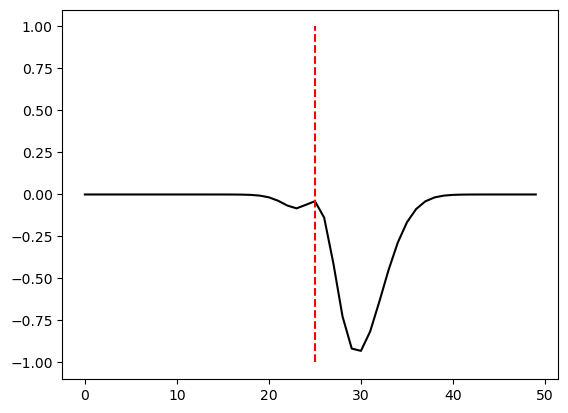

In [5]:

x = np.arange(50)

positive_gaussian = 0.5 * np.exp(-(x - 26)**2 / 5)
negative_gaussian = -1  * np.exp(-(x - 29)**2 / 20)
combined_gaussian = positive_gaussian + negative_gaussian

#plt.plot(x, positive_gaussian, label='Positive Gaussian', color='steelblue')
#plt.plot(x, negative_gaussian, label='Negative Gaussian', color='yellow')
plt.plot(x, combined_gaussian, label='Combined Gaussian', color='k')
plt.vlines(x=25, ymin=-1, ymax=1, color='r', linestyle='--')

# Repeat  the plot for 100 times


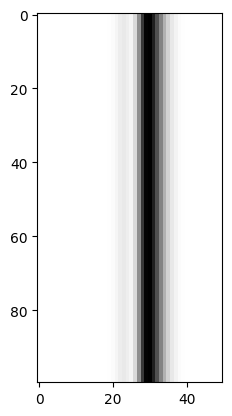

In [ ]:
num_trials = 100


a = np.tile(combined_gaussian, (num_trials, 1))

# a = np.repeat(combined_gaussian, num_trials)
a = np.tile(combined_gaussian, (num_trials, 1))
w = -0.1
vel_pred = w * real_velocity
noise = np.random.normal(0, 1, a.shape)
a = a + vel_pred + noise
plt.imshow(a, cmap='gray')

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import mat73
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from itertools import chain
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from GLM_regression import *
from GLM_regression_plotting import *
plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_SST = "SSTindivsomata_GLM"
filepath_SST = os.path.join(datasets_dir, filename_SST+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_NDNF = "NDNFindivsomata_GLM"
filepath_NDNF = os.path.join(datasets_dir, filename_NDNF+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_EC = "EC_GLM"
filepath_EC = os.path.join(datasets_dir, filename_EC+".mat")

activity_dict_SST, factors_dict_SST = preprocess_data(filepath_SST, normalize=True)
activity_dict_NDNF, factors_dict_NDNF = preprocess_data(filepath_NDNF, normalize=True)
activity_dict_EC, factors_dict_EC = preprocess_data(filepath_EC, normalize=True)

filtered_factors_dict_SST = subset_variables_from_data(factors_dict_SST, variables_to_keep=["Velocity"])
filtered_factors_dict_NDNF = subset_variables_from_data(factors_dict_NDNF, variables_to_keep=["Velocity"])
filtered_factors_dict_EC = subset_variables_from_data(factors_dict_EC, variables_to_keep=["Velocity"])


GLM_params_SST, predicted_activity_dict_SST = fit_GLM_population(filtered_factors_dict_SST, activity_dict_SST, quintile=None, regression='ridge', renormalize=True, alphas=None)

GLM_params_NDNF, predicted_activity_dict_NDNF = fit_GLM_population(filtered_factors_dict_NDNF, activity_dict_NDNF, quintile=None, regression='ridge', renormalize=True, alphas=None)
    
GLM_params_EC, predicted_activity_dict_EC = fit_GLM_population(filtered_factors_dict_EC, activity_dict_EC, quintile=None, regression='ridge', renormalize=True, alphas=None)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Msfin\AppData\Local\Temp\ipykernel_14272\3652006764.py:85: RuntimeWarning: divide by zero encountered in divide
  divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, 0)


MSE Between Ground Truth Place Field and Velcity-Subtracted Residuals 0.4100165411795501


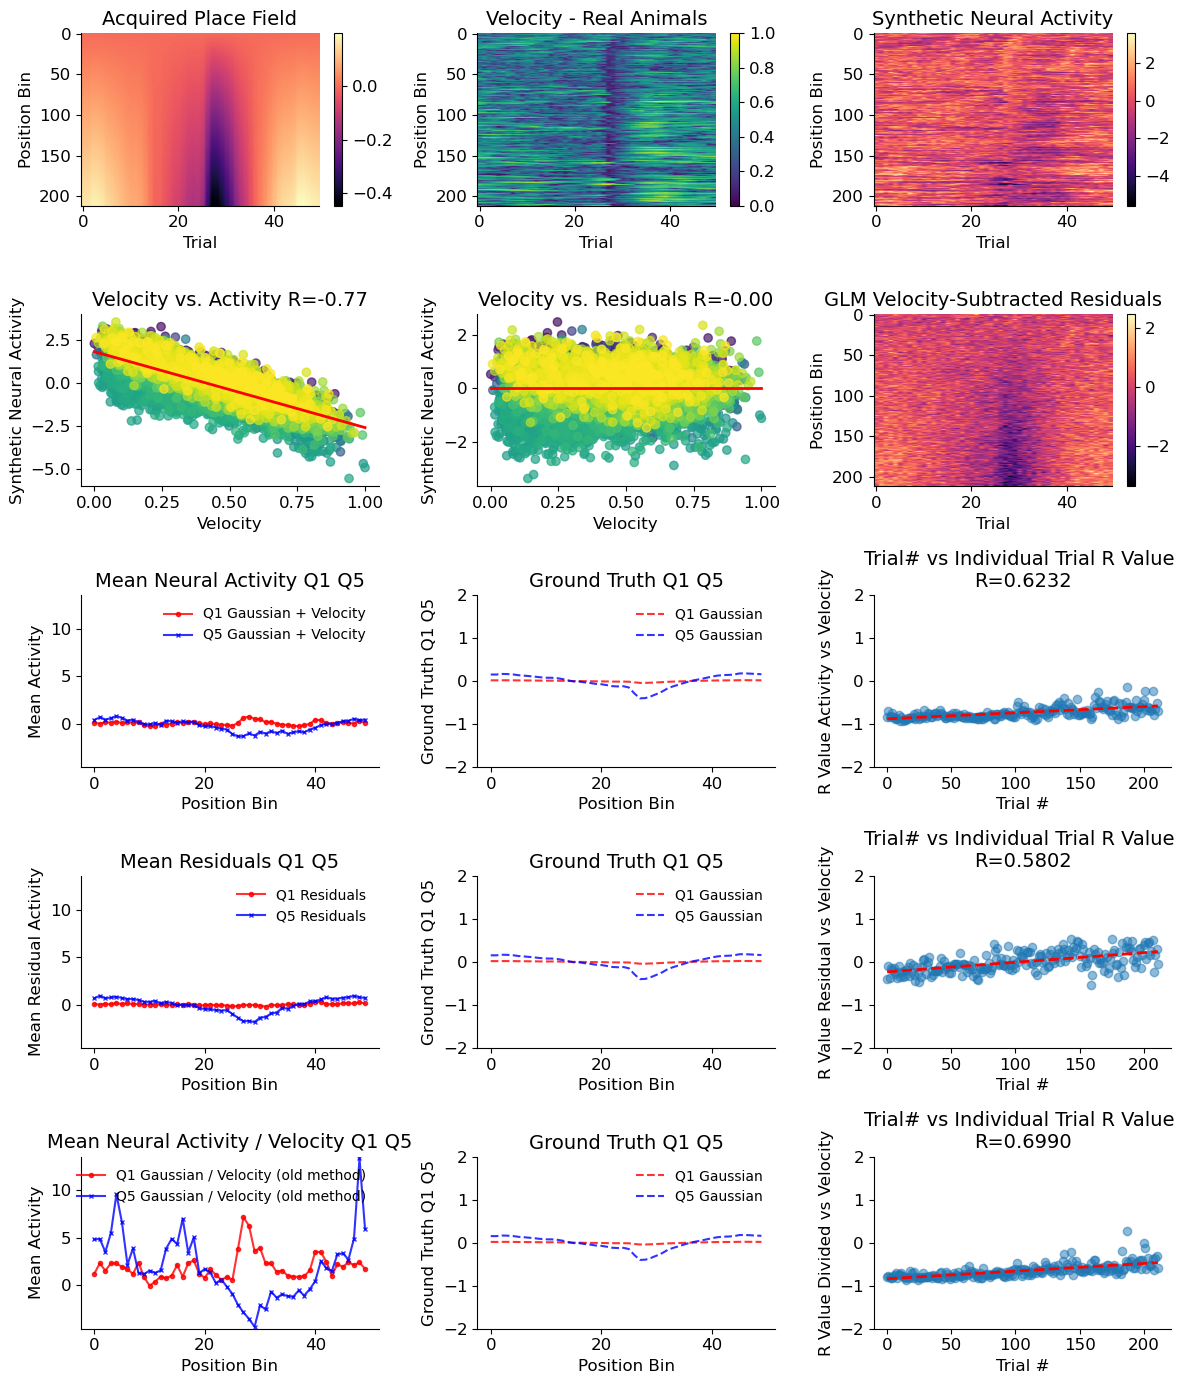

In [139]:
##### velocity plotted over cell trace

from sklearn.linear_model import RidgeCV
from pygam import LinearGAM
import matplotlib.cm as cm


def plot_synthetic_data(weight_type, noise_sf, ramping_field=True, use_GAM=False, power=1, weight_scale=None):
    num_trials=212
    pf_scale = np.linspace(0, 1, num_trials)

    per_cell_velocity = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

    activity_list = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

    neurons_array = np.stack(activity_list) 
    combined_gaussian = np.mean(neurons_array, axis=0)
    num_trials = per_cell_velocity[0].shape[1]
    
    velocity = per_cell_velocity[0]
    
    if weight_type=="flat":
        weight = np.ones(num_trials)
    
    elif weight_type=="ramping_weight":
        weight = pf_scale
        
    elif weight_type=="step_weight":
        weight = np.zeros(num_trials)
        quint = len(weight) // 5  

        for i in range(5):
            weight[i * quint: (i + 1) * quint] = (i + 1) / 5

    weight = weight * weight_scale
  
    velocity_correlation = weight * velocity**(power) 
    
    
    a = np.tile(combined_gaussian, (num_trials, 1)).T

    if ramping_field:
        a = a * pf_scale

    combined_gaussian_with_velocity = a + velocity_correlation
    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape)
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise

    ################# Fitting Model (GLM or GAM)
    
    neuron_activity_flat = combined_gaussian_with_velocity.flatten()
    flattened_data = velocity.flatten().reshape(-1, 1)  # Ensure shape compatibility

    if use_GAM:
        # Fit a Generalized Additive Model (GAM)
        model = LinearGAM().fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)
    else:
        # Fit a Generalized Linear Model (GLM) using Ridge Regression
        alphas = [0.1, 1, 10, 100, 1000, 5000]
        model = RidgeCV(alphas=alphas, cv=None)
        model.fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)

    ################## Plotting Residuals
    
    residual = combined_gaussian_with_velocity - neuron_predicted_activity

    ################## plotting quintiles 


    num_trials = residual.shape[1] 
    quintile_size = num_trials // 5
    
    divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, 0)

    residual_q1 = residual[:, :quintile_size]  # First 1/5th
    residual_q5 = residual[:, -quintile_size:]  # Last 1/5th

    gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
    gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]

    divided_q1 = divide_data_by_velocity[:, :quintile_size]
    divided_q5 = divide_data_by_velocity[:, -quintile_size:]

    mean_residual_q1 = np.mean(residual_q1, axis=1)
    mean_residual_q5 = np.mean(residual_q5, axis=1)

    mean_gaussian_q1 = np.mean(gaussian_q1, axis=1)
    mean_gaussian_q5 = np.mean(gaussian_q5, axis=1)
    
    mean_divided_q1 = np.mean(divided_q1, axis=1)
    mean_divided_q5 = np.mean(divided_q5, axis=1)

    ################## overall correlations

    flat_velocity = velocity.flatten()
    flat_activity = combined_gaussian_with_velocity.flatten()

    velocity_activity_correlation, _ = pearsonr(flat_velocity, flat_activity)

    slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)

    x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals = slope * x_vals + intercept


    flat_residual = residual.flatten()

    velocity_residual_correlation, _ = pearsonr(flat_velocity, flat_residual)
    slope_pred, intercept_pred, r_value_pred, p_value_pred, std_err_pred = linregress(flat_velocity, flat_residual)

    x_vals_pred = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals_pred = slope_pred * x_vals_pred + intercept_pred


    ################### Trial by trial correlations 

    prediction_velocity_correlation_list = []
    activity_velocity_correlation_list = []
    residual_velocity_correlation_list = []
    divided_velocity_correlation_list = []

    for i in range(neuron_predicted_activity.shape[1]):
        trial_predicted_activity = neuron_predicted_activity[:, i]
        trial_velocity = velocity[:, i]
        trial_activity = combined_gaussian_with_velocity[:, i]
        trial_residual = residual[:, i]
        trial_divided = divide_data_by_velocity[:, i]

        prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
        prediction_velocity_correlation_list.append(prediction_velocity_correlation)
        
        activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
        activity_velocity_correlation_list.append(activity_velocity_correlation)
        
        residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
        residual_velocity_correlation_list.append(residual_velocity_correlation)
        
        divided_velocity_correlation, _ = pearsonr(trial_divided, trial_velocity)
        divided_velocity_correlation_list.append(divided_velocity_correlation)

    #############################

    ground_truth_q1 = a[:, :quintile_size]
    ground_truth_q5 = a[:, -quintile_size:]

    mean_truth_q1 = np.mean(ground_truth_q1, axis=1)
    mean_truth_q5 = np.mean(ground_truth_q5, axis=1)

    fig, axs = plt.subplots(5, 3, figsize=(12, 14))  

    im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
    axs[0, 0].set_xlabel("Trial", fontsize=12)
    axs[0, 0].set_ylabel("Position Bin", fontsize=12)
    if ramping_field:
        axs[0, 0].set_title("Acquired Place Field", fontsize=14)
    else:
        axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
    fig.colorbar(im1, ax=axs[0, 0])
    
    MSE = (a-residual)**2
    MSE = np.mean(MSE)
    print(f"MSE Between Ground Truth Place Field and Velcity-Subtracted Residuals {MSE}")

    im3 = axs[0, 1].imshow(velocity.T, cmap='viridis', aspect='auto')
    axs[0, 1].set_title("Velocity - Real Animals", fontsize=14)
    axs[0, 1].set_xlabel("Trial", fontsize=12)
    axs[0, 1].set_ylabel("Position Bin", fontsize=12)
    fig.colorbar(im3, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
    axs[0, 2].set_xlabel("Trial", fontsize=12)
    axs[0, 2].set_ylabel("Position Bin", fontsize=12)
    axs[0, 2].set_title("Synthetic Neural Activity", fontsize=14)
    fig.colorbar(im2, ax=axs[0, 2])

    num_points, num_trials = velocity.shape
    trial_colors = np.repeat(np.linspace(0,1,num_trials), num_points)
    
    cmap = plt.colormaps.get_cmap("viridis")
 
    sc = axs[1, 0].scatter(flat_velocity, flat_activity, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 0].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 0].set_xlabel("Velocity", fontsize=12)
    axs[1, 0].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 0].set_title(f"Velocity vs. Activity R={velocity_activity_correlation:.2f}", fontsize=14)


    sc = axs[1, 1].scatter(flat_velocity, flat_residual, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 1].plot(x_vals_pred, y_vals_pred, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 1].set_xlabel("Velocity", fontsize=12)
    axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 1].set_title(f"Velocity vs. Residuals R={velocity_residual_correlation:.2f}", fontsize=14)

    im5 = axs[1, 2].imshow(residual.T, cmap='magma', aspect='auto')
    axs[1, 2].set_xlabel("Trial", fontsize=12)
    axs[1, 2].set_ylabel("Position Bin", fontsize=12)
    axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
    fig.colorbar(im5, ax=axs[1, 2])


    data_list1 = [mean_gaussian_q1, mean_gaussian_q5, mean_residual_q1, mean_residual_q5, mean_divided_q1, mean_divided_q5]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data1 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data1 = np.min(min_list)
    
    data_list2 = [activity_velocity_correlation_list, residual_velocity_correlation_list, divided_velocity_correlation_list]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data2 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data2 = np.min(min_list)
    
    
    mean_corr_activity = np.mean(activity_velocity_correlation_list)
    mean_corr_residual = np.mean(residual_velocity_correlation_list)
    mean_corr_divide = np.mean(divided_velocity_correlation_list)

    axs[2, 0].plot(mean_gaussian_q1, color='r', label="Q1 Gaussian + Velocity", marker='o', markersize=3, alpha=0.8)
    axs[2, 0].plot(mean_gaussian_q5, color='b', label="Q5 Gaussian + Velocity", marker='x', markersize=3, alpha=0.8)
    axs[2, 0].set_xlabel("Position Bin", fontsize=12)
    axs[2, 0].set_ylabel("Mean Activity", fontsize=12)
    axs[2, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
    axs[2, 0].set_ylim(min_data1-0.2, max_data1+0.2)
    axs[2, 0].legend(fontsize=10)

    axs[2, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[2, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[2, 1].set_xlabel("Position Bin", fontsize=12)
    axs[2, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[2, 1].set_title("Ground Truth Q1 Q5", fontsize=14)
    axs[2, 1].set_ylim(-2, 2)
    axs[2, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(activity_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    activity_corr_array = np.array(activity_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, activity_corr_array)

    axs[2, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
    axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[2, 2].set_xlabel("Trial #", fontsize=12)
    axs[2, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
    axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
    axs[2, 2].set_ylim(-2, 2)
    
    axs[3, 0].plot(mean_residual_q1, color='r', label="Q1 Residuals", marker='o', markersize=3, alpha=0.8)
    axs[3, 0].plot(mean_residual_q5, color='b', label="Q5 Residuals", marker='x', markersize=3, alpha=0.8)
    axs[3, 0].set_xlabel("Position Bin", fontsize=12)
    axs[3, 0].set_ylabel("Mean Residual Activity", fontsize=12)
    axs[3, 0].set_title("Mean Residuals Q1 Q5", fontsize=14)
    axs[3, 0].set_ylim(min_data2-0.2, max_data2+0.2)
    axs[3, 0].legend(fontsize=10)

    axs[3, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[3, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[3, 1].set_xlabel("Position Bin", fontsize=12)
    axs[3, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[3, 1].set_title("Ground Truth Q1 Q5", fontsize=14)
    axs[3, 1].set_ylim(-2, 2)
    axs[3, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(residual_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    residual_corr_array = np.array(residual_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

    axs[3, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
    axs[3, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[3, 2].set_xlabel("Trial #", fontsize=12)
    axs[3, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
    axs[3, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
    axs[3, 2].set_ylim(-2, 2)


#############  Dividing by velocity - Christines original model 
    
    axs[4, 0].plot(mean_divided_q1, color='r', label="Q1 Gaussian / Velocity", marker='o', markersize=3, alpha=0.8)
    axs[4, 0].plot(mean_divided_q5, color='b', label="Q5 Gaussian / Velocity", marker='x', markersize=3, alpha=0.8)
    axs[4, 0].set_xlabel("Position Bin", fontsize=12)
    axs[4, 0].set_ylabel("Mean Activity", fontsize=12)
    axs[4, 0].set_title("Mean Neural Activity / Velocity Q1 Q5", fontsize=14)
    axs[4, 0].set_ylim(min_data2-0.2, max_data2+0.2)
    axs[4, 0].legend(fontsize=10)
    
    axs[4, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[4, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[4, 1].set_xlabel("Position Bin", fontsize=12)
    axs[4, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[4, 1].set_title("Ground Truth Q1 Q5", fontsize=14)
    axs[4, 1].set_ylim(-2, 2)
    axs[4, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(divided_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, divided_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    divided_corr_array = np.array(divided_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, divided_corr_array)

    axs[4, 2].scatter(trial_numbers, divided_velocity_correlation_list, alpha=0.5, label="Data")
    axs[4, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[4, 2].set_xlabel("Trial #", fontsize=12)
    axs[4, 2].set_ylabel("R Value Divided vs Velocity", fontsize=12)
    axs[4, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
    axs[4, 2].set_ylim(-2, 2)

    

    plt.tight_layout() 
    plt.show()

plot_synthetic_data(weight_type="flat", noise_sf=0.5, ramping_field=True, use_GAM=True, power=1, weight_scale=-1)

#flat
#weight="ramping_weight
#weight="step_weight
#### ramping wt still linear just chaning in scale with trial

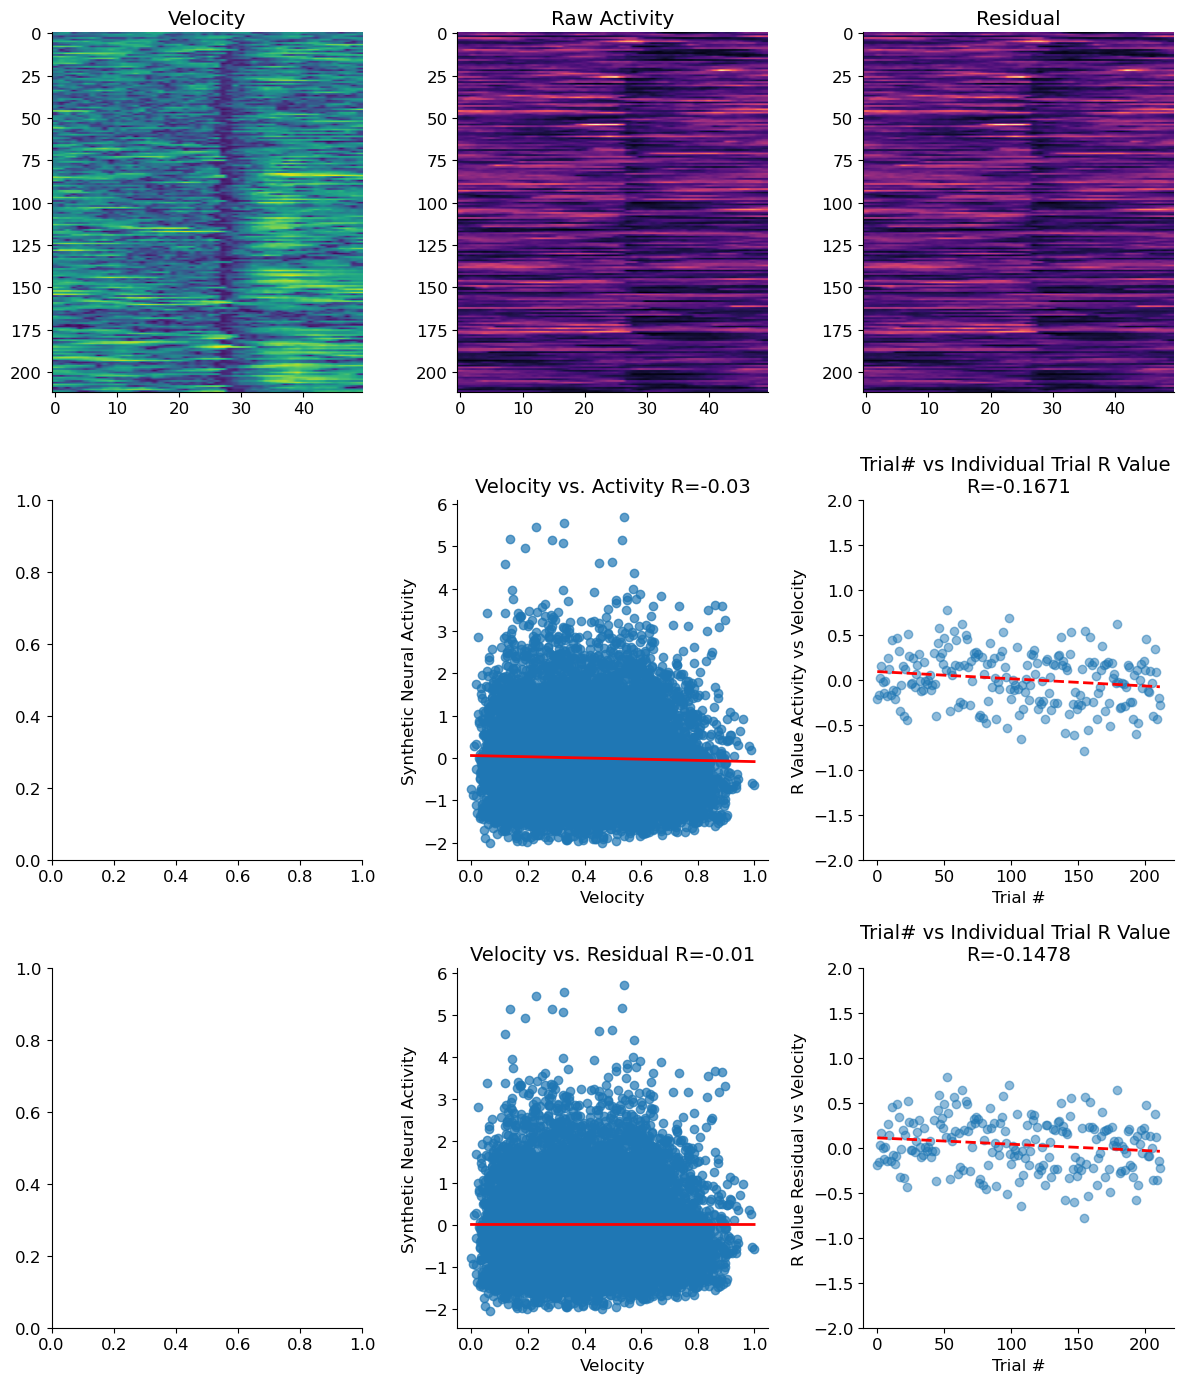

In [149]:

neuron_activity_list, predictions_list, cell_residual_list = get_neuron_activity_prediction_residual(activity_dict_SST, predicted_activity_dict_SST)
velocity = per_cell_velocity[0]
activity = neuron_activity_list[0]
residual = cell_residual_list[0]
prediction = predictions_list[0]

fig, axs = plt.subplots(3,3,  figsize=(12, 14))

axs[0, 0].imshow(velocity.T, aspect="auto")
axs[0, 0].set_title("Velocity")

axs[0, 1].imshow(activity.T, aspect="auto", cmap='magma')
axs[0, 1].set_title("Raw Activity")

axs[0, 2].imshow(residual.T, aspect="auto", cmap='magma')
axs[0, 2].set_title("Residual")

prediction_velocity_correlation_list = []
activity_velocity_correlation_list = []
residual_velocity_correlation_list = []

for i in range(activity.shape[1]):
    trial_predicted_activity = prediction[:, i]
    trial_velocity = velocity[:, i]
    trial_activity = activity[:, i]
    trial_residual = residual[:, i]

    prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
    prediction_velocity_correlation_list.append(prediction_velocity_correlation)

    activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
    activity_velocity_correlation_list.append(activity_velocity_correlation)

    residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
    residual_velocity_correlation_list.append(residual_velocity_correlation)
    
    
    
    
    
num_trials = residual.shape[1] 
quintile_size = num_trials // 5

divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, 0)

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

activity_q1 = activity[:, :quintile_size]
activity_q5 = activity[:, -quintile_size:]

divided_q1 = divide_data_by_velocity[:, :quintile_size]
divided_q5 = divide_data_by_velocity[:, -quintile_size:]

mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_activity_q1 = np.mean(activity_q1, axis=1)
mean_activity_q5 = np.mean(activity_q5, axis=1)

mean_divided_q1 = np.mean(divided_q1, axis=1)
mean_divided_q5 = np.mean(divided_q5, axis=1)



axs[1, 0].plot(mean_gaussian_q1, color='r', label="Q1 Activity", marker='o', markersize=3, alpha=0.8)
axs[1, 0].plot(mean_gaussian_q5, color='b', label="Q5 Activity", marker='x', markersize=3, alpha=0.8)
axs[1, 0].set_xlabel("Position Bin", fontsize=12)
axs[1, 0].set_ylabel("Mean Activity", fontsize=12)
axs[1, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[1, 0].set_ylim(min_data1-0.2, max_data1+0.2)
axs[1, 0].legend(fontsize=10)
    
flat_velocity = velocity.flatten()
flat_activity = activity.flatten()

slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)
x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals = slope * x_vals + intercept

velocity_activity_corr, _ = pearsonr(flat_velocity, flat_activity)
axs[1, 1].scatter(flat_velocity, flat_activity, alpha=0.7)
axs[1, 1].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
axs[1, 1].set_xlabel("Velocity", fontsize=12)
axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[1, 1].set_title(f"Velocity vs. Activity R={velocity_activity_corr:.2f}", fontsize=14)
    
    
    
trial_numbers=np.arange(len(activity_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

activity_corr_array = np.array(activity_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, activity_corr_array)

axs[1, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
axs[1, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[1, 2].set_xlabel("Trial #", fontsize=12)
axs[1, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
axs[1, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[1, 2].set_ylim(-2, 2)





    
flat_velocity = velocity.flatten()
flat_residual = residual.flatten()

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(flat_velocity, flat_residual)
x_vals2 = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals2 = slope * x_vals + intercept2

velocity_residual_corr, _ = pearsonr(flat_velocity, flat_residual)
axs[2, 1].scatter(flat_velocity, flat_residual, alpha=0.7)
axs[2, 1].plot(x_vals2, y_vals2, color='red', linewidth=2, label="Best Fit Line")
axs[2, 1].set_xlabel("Velocity", fontsize=12)
axs[2, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[2, 1].set_title(f"Velocity vs. Residual R={velocity_residual_corr:.2f}", fontsize=14)


    
    
trial_numbers=np.arange(len(residual_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

residual_corr_array = np.array(residual_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

axs[2, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[2, 2].set_xlabel("Trial #", fontsize=12)
axs[2, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[2, 2].set_ylim(-2, 2)












plt.tight_layout()
plt.show()




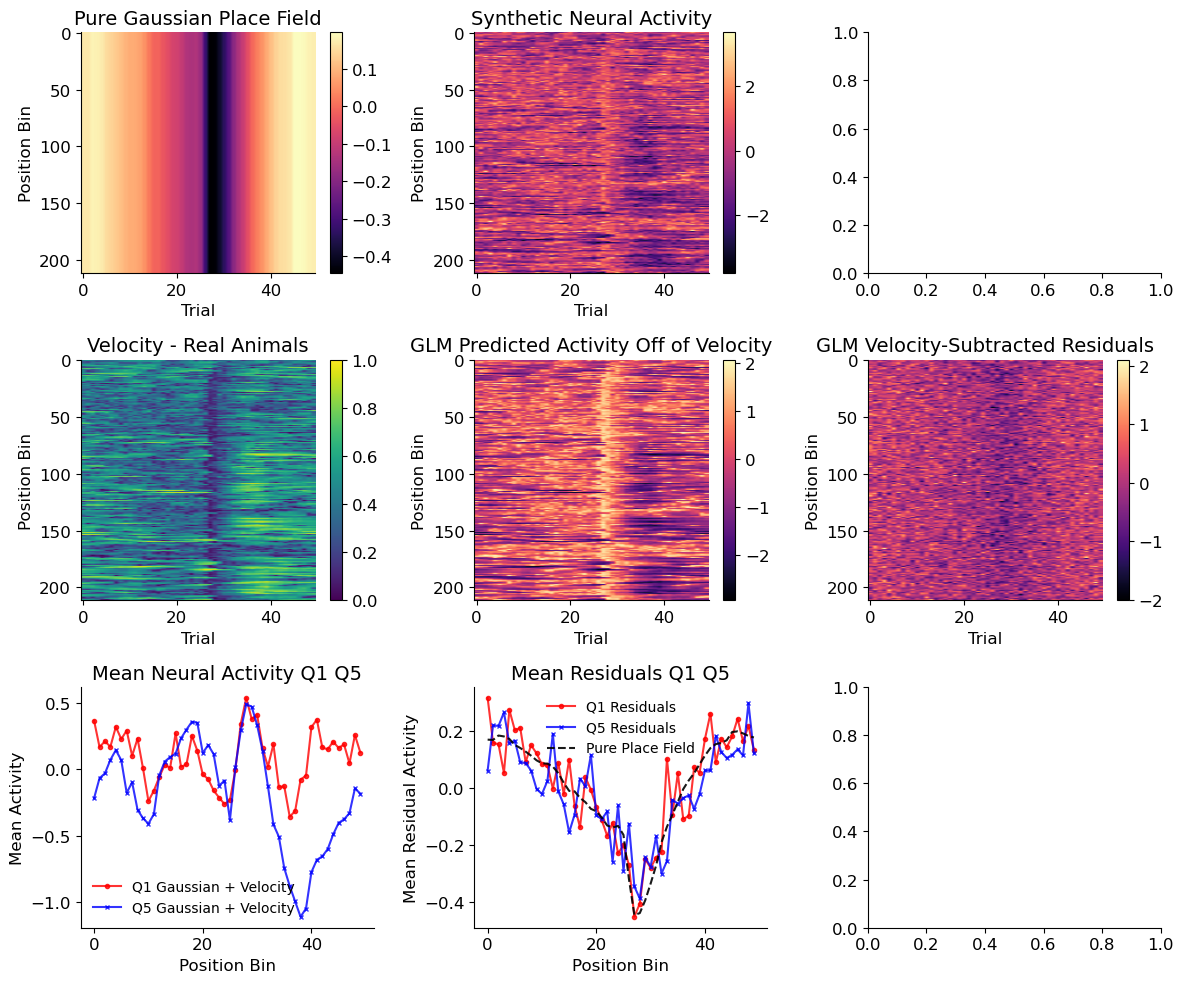

In [5]:
##### velocity plotted over cell trace

weight = -5
noise_sf = 0.5
pf_scale = np.linspace(0, 1, 212)
# pf_position = 


per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)

num_trials = per_cell_velocity[0].shape[1]


################# plotting pure gaussian place fields

a = np.tile(combined_gaussian, (num_trials, 1)).T

################# pure velocity data

velocity = per_cell_velocity[0]

################# plotting velocity-correlated activity


velocity_correlation = weight*velocity

combined_gaussian_with_velocity = a + velocity_correlation

combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

noise = noise_sf * np.random.normal(0, 1, a.shape)
combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise


################# fitting a GLM and getting velocity prediction 

neuron_activity_flat = combined_gaussian_with_velocity.flatten()
flattened_data = velocity.flatten()

alphas=None

model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)


################## plotting the residuals 

residual = combined_gaussian_with_velocity - neuron_predicted_activity


################## plotting quintiles 


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  # First 1/5th
residual_q5 = residual[:, -quintile_size:]  # Last 1/5th

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_gaussian_q1 = np.mean(gaussian_q1, axis=1)
mean_gaussian_q5 = np.mean(gaussian_q5, axis=1)


#############################

fig, axs = plt.subplots(3, 3, figsize=(12, 10))  # Increase figure size

im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
axs[0, 0].set_xlabel("Trial", fontsize=12)
axs[0, 0].set_ylabel("Position Bin", fontsize=12)
axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
axs[0, 1].set_xlabel("Trial", fontsize=12)
axs[0, 1].set_ylabel("Position Bin", fontsize=12)
axs[0, 1].set_title("Synthetic Neural Activity", fontsize=14)
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(velocity.T, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Velocity - Real Animals", fontsize=14)
axs[1, 0].set_xlabel("Trial", fontsize=12)
axs[1, 0].set_ylabel("Position Bin", fontsize=12)
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(neuron_predicted_activity.T, cmap='magma', aspect='auto')
axs[1, 1].set_xlabel("Trial", fontsize=12)
axs[1, 1].set_ylabel("Position Bin", fontsize=12)
axs[1, 1].set_title("GLM Predicted Activity Off of Velocity", fontsize=14)
fig.colorbar(im4, ax=axs[1, 1])

im5 = axs[1, 2].imshow(residual.T, cmap='magma', aspect='auto')
axs[1, 2].set_xlabel("Trial", fontsize=12)
axs[1, 2].set_ylabel("Position Bin", fontsize=12)
axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
fig.colorbar(im5, ax=axs[1, 2])

axs[2, 0].plot(mean_gaussian_q1, color='r', label="Q1 Gaussian + Velocity", marker='o', markersize=3, alpha=0.8)
axs[2, 0].plot(mean_gaussian_q5, color='b', label="Q5 Gaussian + Velocity", marker='x', markersize=3, alpha=0.8)
axs[2, 0].set_xlabel("Position Bin", fontsize=12)
axs[2, 0].set_ylabel("Mean Activity", fontsize=12)
axs[2, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[2, 0].legend(fontsize=10)

axs[2, 1].plot(mean_residual_q1, color='r', label="Q1 Residuals", marker='o', markersize=3, alpha=0.8)
axs[2, 1].plot(mean_residual_q5, color='b', label="Q5 Residuals", marker='x', markersize=3, alpha=0.8)
axs[2, 1].plot(combined_gaussian, color="k", label="Pure Place Field", linestyle="--", alpha=0.9)
axs[2, 1].set_xlabel("Position Bin", fontsize=12)
axs[2, 1].set_ylabel("Mean Residual Activity", fontsize=12)
axs[2, 1].set_title("Mean Residuals Q1 Q5", fontsize=14)
axs[2, 1].legend(fontsize=10)

plt.tight_layout() 
plt.show()



residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_vel_corr_pos_q1 [-0.0076497057076108455, -0.012036099640309756, 0.02450870221599025]
residual_vel_corr_pos_q5 [-0.03662737347023687, -0.020470508843963727, -0.021610943728932873]
residual_vel_corr_neg_q1 []
residual_vel_corr_neg_q5 []


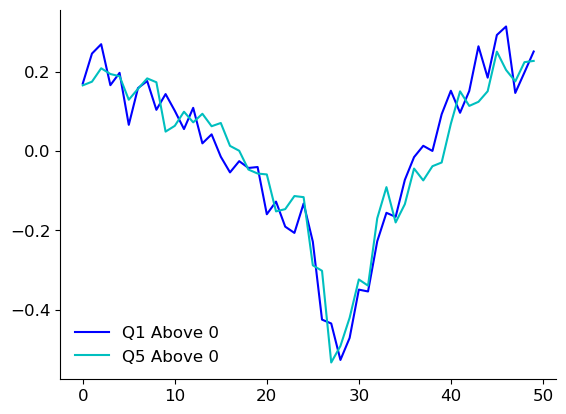

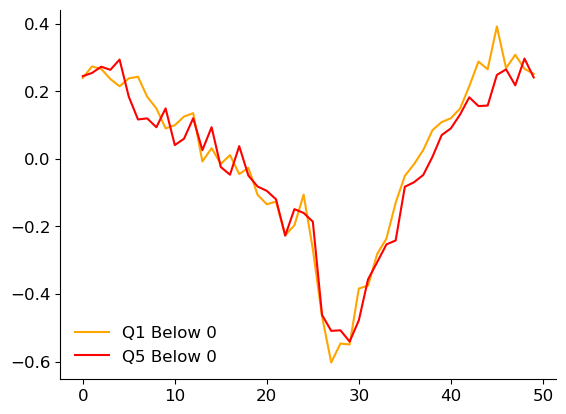

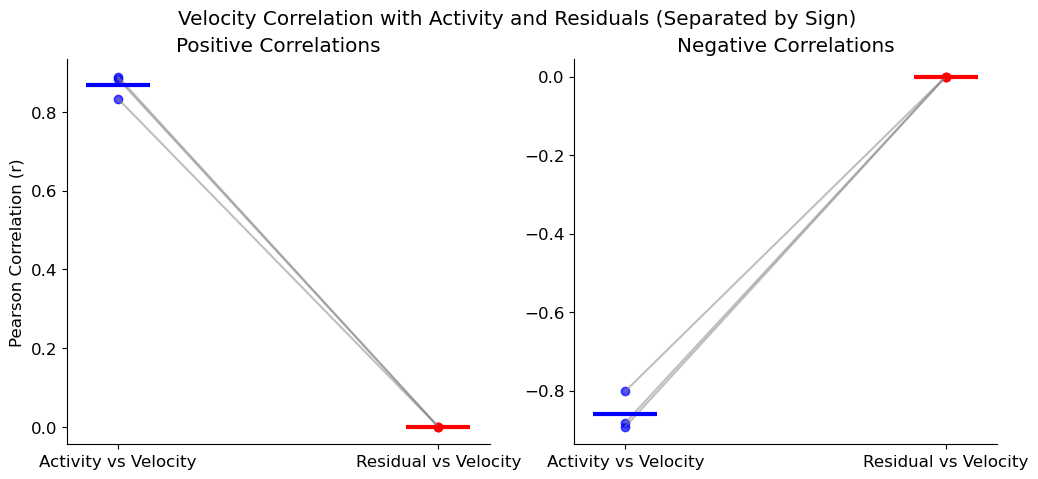

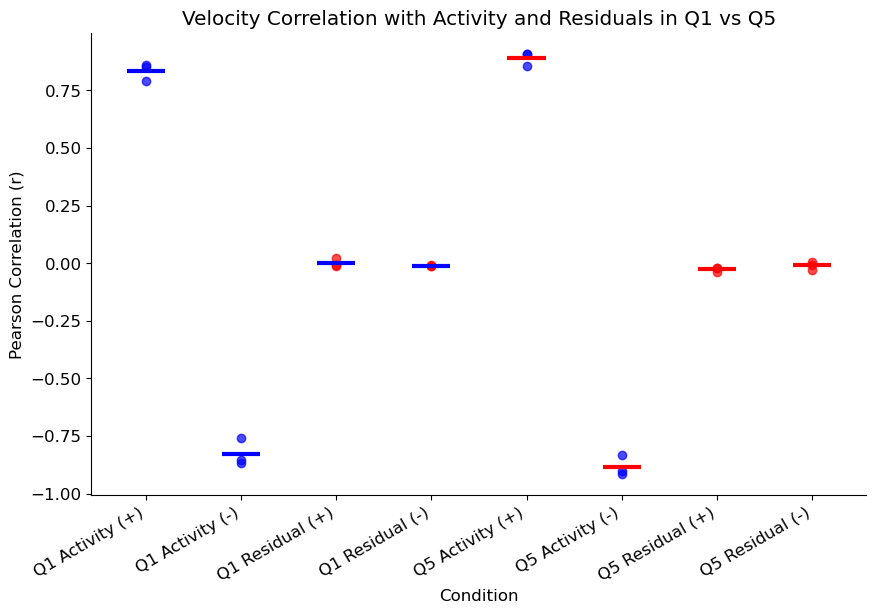

In [103]:
noise_sf=0.5

per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)
combined_gaussian = np.tile(combined_gaussian, (num_trials, 1)).T


weights_list_positive = [2, 5, 10]
weights_list_negative = [-2, -5, -10]

gaussian_positive = []
gaussian_negative = []

for weight in weights_list_positive:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_positive.append(combined_gaussian_with_velocity.T)
    
for weight in weights_list_negative:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_negative.append(combined_gaussian_with_velocity.T)
    

    
velocity = per_cell_velocity[0].T

positive_prediction_list = []
negative_prediction_list = []

for i in gaussian_positive:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    positive_prediction_list.append(neuron_predicted_activity)
    
for i in gaussian_negative:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    negative_prediction_list.append(neuron_predicted_activity)
    
residuals_list_positive = np.subtract(gaussian_positive, positive_prediction_list)
residuals_list_negative = np.subtract(gaussian_negative, negative_prediction_list)


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


residual_list_pos_q1 = []
residual_list_pos_q5 = []
mean_residual_list_pos_q1 = []
mean_residual_list_pos_q5 = []

residual_vel_corr_pos_q1 = []
residual_vel_corr_pos_q5 = []
activity_vel_corr_pos_q1 = []
activity_vel_corr_pos_q5 = []

for idx, i in enumerate(residuals_list_positive):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    print(f"residual_q1.shape {residual_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    residual_list_pos_q1.append(residual_q1)
    residual_list_pos_q5.append(residual_q5)
    mean_residual_list_pos_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_pos_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    
    residual_vel_corr_pos_q1.append(q1_corr)
    residual_vel_corr_pos_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_positive[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_positive[idx].T[:, -quintile_size:] 
    
    print(f"gaussian_q1.shape {gaussian_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_pos_q1.append(q1_corr_activity)
    activity_vel_corr_pos_q5.append(q5_corr_activity)
    
print(f"residual_vel_corr_pos_q1 {residual_vel_corr_pos_q1}")
print(f"residual_vel_corr_pos_q5 {residual_vel_corr_pos_q5}")
    
    
residual_list_neg_q1 = []
residual_list_neg_q5 = []
mean_residual_list_neg_q1 = []
mean_residual_list_neg_q5 = []

residual_vel_corr_neg_q1 = []
residual_vel_corr_neg_q5 = []
activity_vel_corr_neg_q1 = []
activity_vel_corr_neg_q5 = []

print(f"residual_vel_corr_neg_q1 {residual_vel_corr_neg_q1}")
print(f"residual_vel_corr_neg_q5 {residual_vel_corr_neg_q5}")

for idx, i in enumerate(residuals_list_negative):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    residual_list_neg_q1.append(residual_q1)
    residual_list_neg_q5.append(residual_q5)
    mean_residual_list_neg_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_neg_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    residual_vel_corr_neg_q1.append(q1_corr)
    residual_vel_corr_neg_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_negative[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_negative[idx].T[:, -quintile_size:]
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_neg_q1.append(q1_corr_activity)
    activity_vel_corr_neg_q5.append(q5_corr_activity)
    
        
        
activity_velocity_positive = []
activity_velocity_negative = []

residual_velocity_positive = []
residual_velocity_negative = []


for i in range(len(residual_list_pos_q1)):
    raw_positive = gaussian_positive[i].flatten()
    raw_negative = gaussian_negative[i].flatten()
    res_pos = residuals_list_positive[i].flatten()
    res_neg = residuals_list_negative[i].flatten()
    flat_velocity = velocity.flatten()
    positive_correlation, _ = pearsonr(raw_positive, flat_velocity)
    negative_correlation, _ = pearsonr(raw_negative, flat_velocity)
    activity_velocity_positive.append(positive_correlation)
    activity_velocity_negative.append(negative_correlation)
    res_pos_corr, _ = pearsonr(res_pos, flat_velocity)
    res_neg_corr, _ = pearsonr(res_neg, flat_velocity)
    residual_velocity_positive.append(res_pos_corr)
    residual_velocity_negative.append(res_neg_corr)

    
mean_residual_list_pos_q1_array = np.stack(mean_residual_list_pos_q1)
mean_residual_list_pos_q1_array = np.mean(mean_residual_list_pos_q1_array, axis=0)

mean_residual_list_pos_q5_array = np.stack(mean_residual_list_pos_q5)
mean_residual_list_pos_q5_array = np.mean(mean_residual_list_pos_q5_array, axis=0)

mean_residual_list_neg_q1_array = np.stack(mean_residual_list_neg_q1)
mean_residual_list_neg_q1_array = np.mean(mean_residual_list_neg_q1_array, axis=0)

mean_residual_list_neg_q5_array = np.stack(mean_residual_list_neg_q5)
mean_residual_list_neg_q5_array = np.mean(mean_residual_list_neg_q5_array, axis=0)


plt.figure()
plt.plot(mean_residual_list_pos_q1_array, color='b', label="Q1 Above 0")
plt.plot(mean_residual_list_pos_q5_array, color='c', label="Q5 Above 0")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_residual_list_neg_q1_array, color='orange', label="Q1 Below 0")
plt.plot(mean_residual_list_neg_q5_array, color='r', label="Q5 Below 0")
plt.legend()
plt.show()

#############################################################


min_len_pos = min(len(activity_velocity_positive), len(residual_velocity_positive))
min_len_neg = min(len(activity_velocity_negative), len(residual_velocity_negative))

# Truncate lists to match the minimum length
activity_velocity_positive = activity_velocity_positive[:min_len_pos]
residual_velocity_positive = residual_velocity_positive[:min_len_pos]

activity_velocity_negative = activity_velocity_negative[:min_len_neg]
residual_velocity_negative = residual_velocity_negative[:min_len_neg]

# Define x positions for Activity vs Velocity (x=1) and Residual vs Velocity (x=2)
x_pos_activity = np.full(len(activity_velocity_positive), 1)
x_pos_residual = np.full(len(residual_velocity_positive), 2)

x_neg_activity = np.full(len(activity_velocity_negative), 1)
x_neg_residual = np.full(len(residual_velocity_negative), 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Positive Correlations Plot
axes[0].scatter(x_pos_activity, activity_velocity_positive, color='b', alpha=0.7, label="Activity Positive")
axes[0].scatter(x_pos_residual, residual_velocity_positive, color='r', alpha=0.7, label="Residual Positive")

for i in range(len(activity_velocity_positive)):
    axes[0].plot([1, 2], [activity_velocity_positive[i], residual_velocity_positive[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[0].hlines(np.mean(activity_velocity_positive), 0.9, 1.1, color='b', linewidth=3)
axes[0].hlines(np.mean(residual_velocity_positive), 1.9, 2.1, color='r', linewidth=3)

axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[0].set_ylabel("Pearson Correlation (r)")
axes[0].set_title("Positive Correlations")

# Negative Correlations Plot
axes[1].scatter(x_neg_activity, activity_velocity_negative, color='b', alpha=0.7, label="Activity Negative")
axes[1].scatter(x_neg_residual, residual_velocity_negative, color='r', alpha=0.7, label="Residual Negative")

for i in range(len(activity_velocity_negative)):
    axes[1].plot([1, 2], [activity_velocity_negative[i], residual_velocity_negative[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[1].hlines(np.mean(activity_velocity_negative), 0.9, 1.1, color='b', linewidth=3)
axes[1].hlines(np.mean(residual_velocity_negative), 1.9, 2.1, color='r', linewidth=3)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[1].set_title("Negative Correlations")

plt.suptitle("Velocity Correlation with Activity and Residuals (Separated by Sign)")
plt.show()



#####################################################################

q1_corr_values = [
    activity_vel_corr_pos_q1, activity_vel_corr_neg_q1,
    residual_vel_corr_pos_q1, residual_vel_corr_neg_q1
]

q5_corr_values = [
    activity_vel_corr_pos_q5, activity_vel_corr_neg_q5,
    residual_vel_corr_pos_q5, residual_vel_corr_neg_q5
]

labels = ["Q1 Activity (+)", "Q1 Activity (-)", "Q1 Residual (+)", "Q1 Residual (-)",
          "Q5 Activity (+)", "Q5 Activity (-)", "Q5 Residual (+)", "Q5 Residual (-)"]

x_positions_q1 = np.arange(1, 5)
x_positions_q5 = np.arange(5, 9)

plt.figure(figsize=(10, 6))

# Plot Q1 correlations
for i, data in enumerate(q1_corr_values):
    plt.scatter([x_positions_q1[i]] * len(data), data, color='b' if "Activity" in labels[i] else 'r', alpha=0.7)

# Plot Q5 correlations
for i, data in enumerate(q5_corr_values):
    plt.scatter([x_positions_q5[i]] * len(data), data, color='b' if "Activity" in labels[i + 4] else 'r', alpha=0.7)

# Mean lines
means_q1 = [np.mean(data) for data in q1_corr_values]
means_q5 = [np.mean(data) for data in q5_corr_values]

plt.hlines(means_q1, x_positions_q1 - 0.2, x_positions_q1 + 0.2, color='b', linewidth=3)
plt.hlines(means_q5, x_positions_q5 - 0.2, x_positions_q5 + 0.2, color='r', linewidth=3)

plt.xticks(np.concatenate([x_positions_q1, x_positions_q5]), labels, rotation=30, ha="right")
plt.xlabel("Condition")
plt.ylabel("Pearson Correlation (r)")
plt.title("Velocity Correlation with Activity and Residuals in Q1 vs Q5")
plt.show()

